# Explore AIMed Dataset


### AIMed dataset preprocessing

 - Download from ftp://ftp.cs.utexas.edu/pub/mooney/bio-data/interactions.tar.gz"

 - Convert the raw dataset into XML for using instructions in http://mars.cs.utu.fi/PPICorpora/ 
 
 ```python
 convert_aimed.py -i  aimed_interactions_input_dir -o aimed.xml
 ```

Acknowledgements:
 Pyysalo S, Airola A, Heimonen J, Björne J, Ginter F, Salakoski T, Comparative Analysis of Five Protein-protein Interaction Corpora, LBM'07. 2007.


In [1]:
xmlfile = "aimed.xml"

In [2]:
s3_bucket ="s3://aegovan-data/aimed/"

In [3]:
import sys
sys.path.append('./source')

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

#### Covert to pandas

In [5]:
from datatransformer.AimedXmlToDataFramePreprocessed import AimedXmlToDataFramePreprocessed
df_processed = AimedXmlToDataFramePreprocessed()(xmlfile)


In [6]:
df_processed.query("docid=='AIMed.d35'")

,docid,isValid,passage,passageid
696,AIMed.d35,False,Most familial early-onset Alzheimer's disease cases are caused by mutations in the PROTEIN1 ( PROTEIN2 ) gene.,AIMed.d35.s292
697,AIMed.d35,False,"Although numerous studies revealed predominant localization of PROTEIN1 to endoplasmic reticulum and Golgi, there are conflicting reports on the localization of PROTEIN2 to the cell surface.",AIMed.d35.s294
698,AIMed.d35,False,"Cell surface PROTEIN formed complexes in vivo with actin-binding protein PROTEIN1 ( PROTEIN2 ), which is known to form bridges between cell surface receptors and cytoskeleton and mediate cell adhesion and cell motility.",AIMed.d35.s299
699,AIMed.d35,True,"Cell surface PROTEIN1 formed complexes in vivo with actin-binding protein PROTEIN2 ( PROTEIN ), which is known to form bridges between cell surface receptors and cytoskeleton and mediate cell adhesion and cell motility.",AIMed.d35.s299
700,AIMed.d35,True,"Cell surface PROTEIN1 formed complexes in vivo with actin-binding protein PROTEIN ( PROTEIN2 ), which is known to form bridges between cell surface receptors and cytoskeleton and mediate cell adhesion and cell motility.",AIMed.d35.s299


In [7]:
df_processed.shape

(5834, 4)

In [8]:
df_processed.head(n=2)

,docid,isValid,passage,passageid
0,AIMed.d0,False,"Cytokines measurements during PROTEIN1 treatment showed a trend to decreasing levels of PROTEIN2 at 4, 12, and 24 weeks.",AIMed.d0.s5
1,AIMed.d0,False,Levels of PROTEIN1 were slightly increased following PROTEIN2 treatment (P = 0.09).,AIMed.d0.s6


In [9]:
unique_passages = df_processed["passageid"].unique()
print("Unique sentences :  " , len(unique_passages))

Unique sentences :   1169


### Explore dataset - Preprocessed

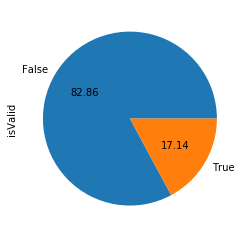

In [10]:
import matplotlib.pyplot as plt

df_processed["isValid"].value_counts().plot.pie(autopct='%.2f',figsize=(4, 4))
plt.show()

In [11]:
df_processed["isValid"].value_counts()

False    4834
True     1000
Name: isValid, dtype: int64

In [12]:
data_file="AIMedFull_preprocessed.json"
df_processed.to_json(data_file)

In [13]:
!aws s3 cp $data_file $s3_bucket

upload: ./AIMedFull_preprocessed.json to s3://aegovan-data/aimed/AIMedFull_preprocessed.json


## Split into train/test/validation  - Preprocessed

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

unique_docids = df_processed.docid.unique()
stratified =  [ df_processed.query("docid == '{}'".format(p))['isValid'].iloc[0] for p in unique_docids]
traindocid, valdocid = train_test_split(unique_docids,  test_size=.1,
                                                        random_state=777, stratify=stratified)

In [15]:
train = df_processed[df_processed['docid'].isin(traindocid)]
val = df_processed[df_processed['docid'].isin(valdocid)]




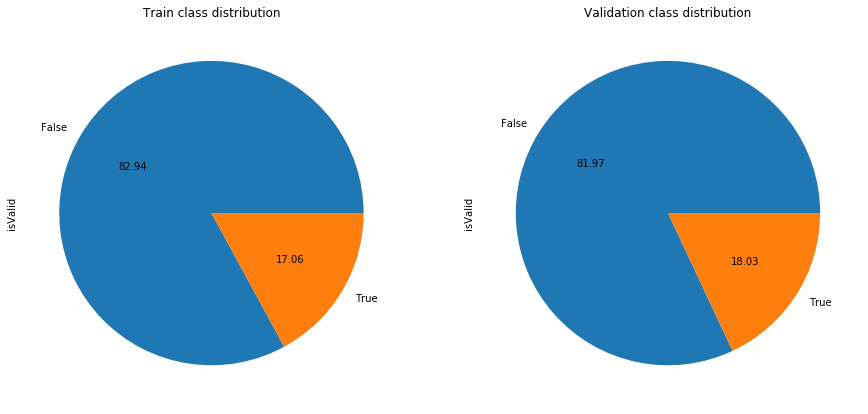

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(15,20))

ax[0].set_title('Train class distribution')
train.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])



plt.show()

In [17]:
data_train_file = "AIMedtrain_preprocessed.json"
data_val_file = "AIMedval_preprocessed.json"
train.to_json(data_train_file)
val.to_json(data_val_file)

In [18]:
!aws s3 cp $data_train_file $s3_bucket
!aws s3 cp $data_val_file $s3_bucket

upload: ./AIMedtrain_preprocessed.json to s3://aegovan-data/aimed/AIMedtrain_preprocessed.json
upload: ./AIMedval_preprocessed.json to s3://aegovan-data/aimed/AIMedval_preprocessed.json


In [19]:
val.isValid.value_counts()

False    382
True      84
Name: isValid, dtype: int64

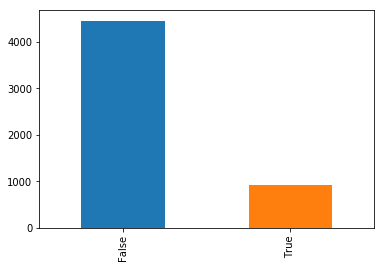

In [20]:
train.isValid.value_counts().plot.bar()

In [21]:
word_count= train.apply(lambda r: len(r["passage"].split(" ")), axis=1)

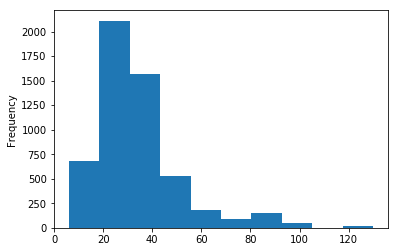

In [22]:
word_count.plot.hist()

In [23]:
train.sample(n=20).to_json("Aimedsample_preprocessed.json")

## Split into train/validation without looking at pubmed overlap -  Preprocessed

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split


train_p, val_p = train_test_split(df_processed,  test_size=.1,
                                                        random_state=777, stratify=df_processed["isValid"])

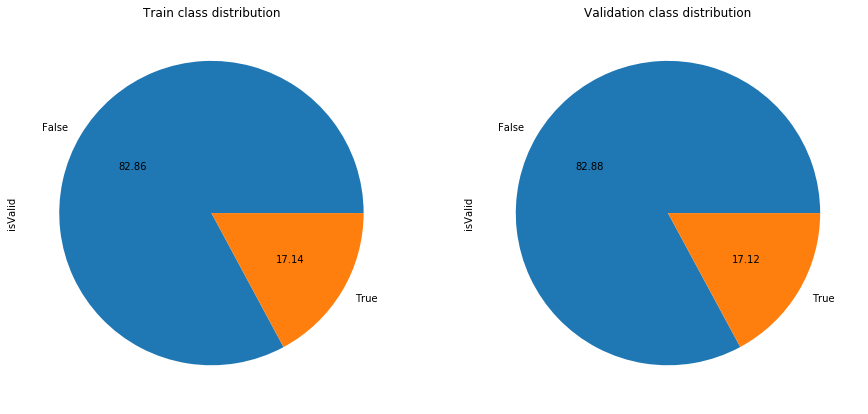

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(15,20))

ax[0].set_title('Train class distribution')
train_p.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution')
val_p.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])



plt.show()

In [26]:

data_train_file_p = "AIMedtrain_pubmedoverlap_preprocessed.json"
data_val_file_p="AIMedval_pubmedoverlap_preprocessed.json"
train_p.to_json(data_train_file_p)
val_p.to_json(data_val_file_p)

In [27]:
!aws s3 cp $data_train_file_p $s3_bucket
!aws s3 cp $data_val_file_p $s3_bucket

upload: ./AIMedtrain_pubmedoverlap_preprocessed.json to s3://aegovan-data/aimed/AIMedtrain_pubmedoverlap_preprocessed.json
upload: ./AIMedval_pubmedoverlap_preprocessed.json to s3://aegovan-data/aimed/AIMedval_pubmedoverlap_preprocessed.json


In [28]:
val_p.isValid.value_counts()

False    484
True     100
Name: isValid, dtype: int64

In [29]:
train_p.isValid.value_counts()

False    4350
True      900
Name: isValid, dtype: int64

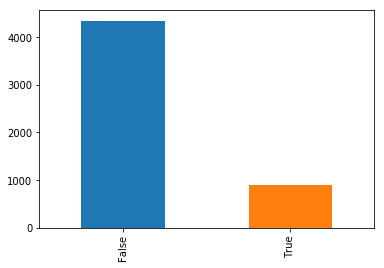

In [30]:
train_p.isValid.value_counts().plot.bar()

## No preprocessing

In [31]:
from datatransformer.AimedXmlToDataFrame import AimedXmlToDataFrame
df_not_processed = AimedXmlToDataFrame()(xmlfile)

In [32]:
df_not_processed["isValid"].value_counts()

False    4834
True     1000
Name: isValid, dtype: int64

In [33]:
df_not_processed.query("docid=='AIMed.d35'")

,docid,isValid,participant1,participant1_loc,participant2,participant2_loc,passage,passageid
696,AIMed.d35,False,presenilin 1,83-94,PS1,97-99,Most familial early-onset Alzheimer's disease cases are caused by mutations in the presenilin 1 (PS1) gene.,AIMed.d35.s292
697,AIMed.d35,False,PS1,156-158,PS1,63-65,"Although numerous studies revealed predominant localization of PS1 to endoplasmic reticulum and Golgi, there are conflicting reports on the localization of PS1 to the cell surface.",AIMed.d35.s294
698,AIMed.d35,False,filamin,69-75,ABP-280,78-84,"Cell surface PS1 formed complexes in vivo with actin-binding protein filamin (ABP-280), which is known to form bridges between cell surface receptors and cytoskeleton and mediate cell adhesion and cell motility.",AIMed.d35.s299
699,AIMed.d35,True,PS1,13-15,filamin,69-75,"Cell surface PS1 formed complexes in vivo with actin-binding protein filamin (ABP-280), which is known to form bridges between cell surface receptors and cytoskeleton and mediate cell adhesion and cell motility.",AIMed.d35.s299
700,AIMed.d35,True,PS1,13-15,ABP-280,78-84,"Cell surface PS1 formed complexes in vivo with actin-binding protein filamin (ABP-280), which is known to form bridges between cell surface receptors and cytoskeleton and mediate cell adhesion and cell motility.",AIMed.d35.s299


### Explore dataset -  no preprocess

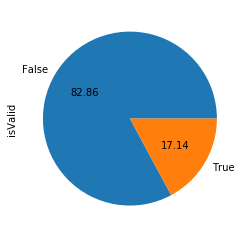

In [34]:
import matplotlib.pyplot as plt

df_not_processed["isValid"].value_counts().plot.pie(autopct='%.2f',figsize=(4, 4))
plt.show()

In [35]:
df_not_processed["isValid"].value_counts()

False    4834
True     1000
Name: isValid, dtype: int64

In [36]:
data_file_not_processed = "AIMedFull.json"
df_not_processed.to_json(data_file_not_processed)

In [37]:
!aws s3 cp $data_file_not_processed $s3_bucket

upload: ./AIMedFull.json to s3://aegovan-data/aimed/AIMedFull.json


## Split into train/test/validation  - no preprocess

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

unique_docids = df_not_processed.docid.unique()
stratified =  [ df_not_processed.query("docid == '{}'".format(p))['isValid'].iloc[0] for p in unique_docids]
traindocid_np, valdocid_np = train_test_split(unique_docids,  test_size=.1,
                                                        random_state=777, stratify=stratified)

In [39]:
train_notprocessed = df_not_processed[df_not_processed['docid'].isin(traindocid_np)]
val_notprocessed = df_not_processed[df_not_processed['docid'].isin(valdocid_np)]




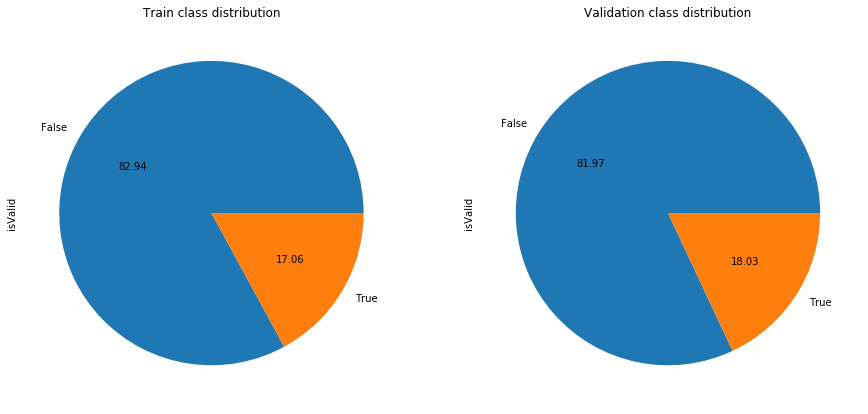

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(15,20))

ax[0].set_title('Train class distribution')
train_notprocessed.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution')
val_notprocessed.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])



plt.show()

In [41]:
train_file_not_processed = "AIMedtrain.json"
val_file_not_processed="AIMedval.json"
train_notprocessed.to_json(train_file_not_processed)
val_notprocessed.to_json(val_file_not_processed)

In [42]:
!aws s3 cp $train_file_not_processed $s3_bucket
!aws s3 cp $val_file_not_processed $s3_bucket

upload: ./AIMedtrain.json to s3://aegovan-data/aimed/AIMedtrain.json
upload: ./AIMedval.json to s3://aegovan-data/aimed/AIMedval.json   


In [43]:
val_notprocessed.isValid.value_counts()

False    382
True      84
Name: isValid, dtype: int64

In [44]:
train_notprocessed.isValid.value_counts()

False    4452
True      916
Name: isValid, dtype: int64

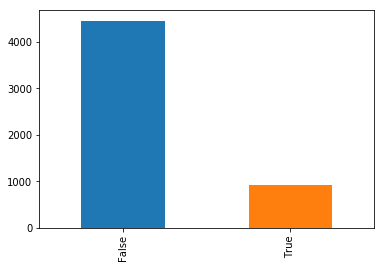

In [45]:
train_notprocessed.isValid.value_counts().plot.bar()

In [46]:
word_count= train_notprocessed.apply(lambda r: len(r["passage"].split(" ")), axis=1)

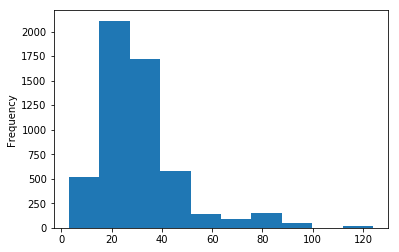

In [47]:
word_count.plot.hist()

In [48]:
train_notprocessed.sample(n=20).to_json("Aimedsample.json")

In [49]:
assert train_notprocessed.shape[0] == train.shape[0]

## Split into train/validation without looking at pubmed overlap  - no preprocess

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split


train_np_p, val_np_p = train_test_split(df_not_processed,  test_size=.1,
                                                        random_state=777, stratify=df_not_processed["isValid"])

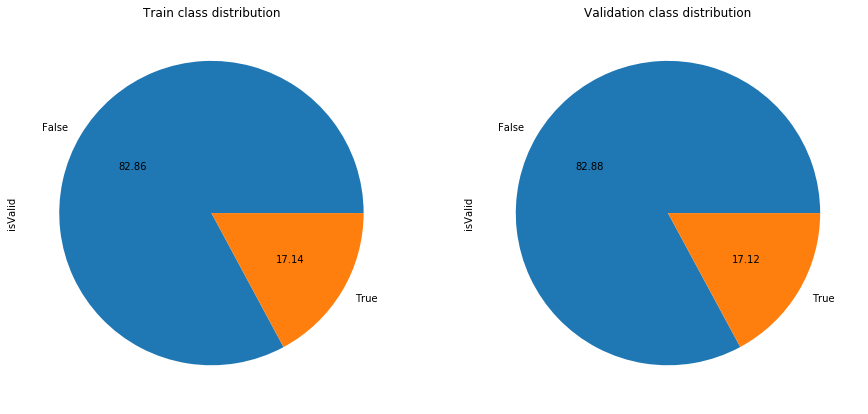

In [51]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(15,20))

ax[0].set_title('Train class distribution')
train_np_p.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution')
val_np_p.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])



plt.show()

In [52]:
train_np_p.to_json("AIMedtrain_pubmedoverlap.json")
val_np_p.to_json("AIMedval_pubmedoverlap.json")

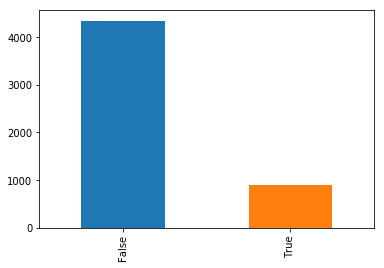

In [53]:
train_np_p.isValid.value_counts().plot.bar()